# Visualising high-dimensional data

## Introduction

In this project I will explore a range of techniques for visualising very high dimensional datasets (which can be very challenging to observe & understand). Visualising higher dimensional datasets can have various purposes & objectives such as:

- Understanding the dataset & subject it represents better
- Preparing the data for machine learning algorithms

We will use the famous MNIST dataset of handwritten digit images which has 784 dimensions/features per image.

The techniques we will use to visualise this dataset will be:

- PCA (Principal components analysis)
- t-SNE (t-Distributed Stochastic Neighbor Embedding)
- TDA (Topological data analysis)

These are different techniques that aim to reduce down a datasets complexity to something easier to understand, either for humans or for machine learning algorithms (i.e. for classification).


## Load libraries and view dataset

In [1]:
# Import libs
from __future__ import print_function
import time
import numpy as np
import pandas as pd
try:
    import umap
except ImportError:
    print("This example requires the UMAP library. You can install it with the command `!pip install umap-learn`")
import warnings
warnings.filterwarnings("ignore")
import sklearn
from sklearn import datasets
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt
import io
import sys
import base64
import matplotlib.pyplot as plt
import kmapper as km
import scipy
import imageio
import seaborn as sns

%matplotlib inline

In [2]:
# Load dataset
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
print(X.shape, y.shape)

(70000, 784) (70000,)


In [3]:
# Convert feature matrix X and target vector y to a pandas dataframe.
feat_cols = [ 'pixel'+str(i) for i in range(X.shape[1]) ]
df = pd.DataFrame(X,columns=feat_cols)
df['y'] = y
df['label'] = df['y'].apply(lambda i: str(i))
X, y = None, None
print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (70000, 786)


In [4]:
# For reproducability of the results
np.random.seed(42)
# Take random subset of digit images so we get a range of examples for each digit
rndperm = np.random.permutation(df.shape[0])

<Figure size 432x288 with 0 Axes>

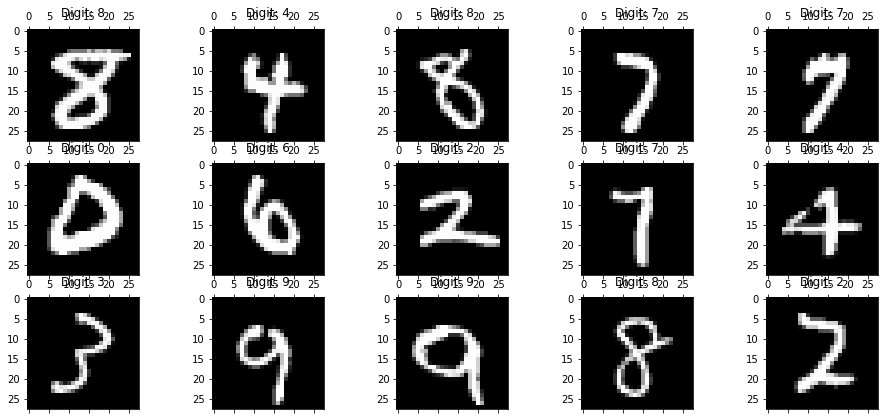

In [5]:
# Print examples
plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1, title="Digit: {}".format(str(df.loc[rndperm[i],'label'])) )
    ax.matshow(df.loc[rndperm[i],feat_cols].values.reshape((28,28)).astype(float))
plt.show()

## Reduce dimensionality using PCA

Principal component analysis (PCA) is a technique used for identification of a smaller number of uncorrelated variables known as principal components from a larger set of data. The technique is widely used to emphasize variation and capture strong patterns in a data set.

Typically this technique is used to reduce the data down to a smaller number of dimensions (i.e. 2-3) while aiming to retain the maximum amount of variability in the dataset. We can then plot this 2/3 dimensional data on a 2d/3d scatter plot to make it easier to observe patterns visually in the data.

Below we will now apply PCA to the MNIST data and extract it's principal components.

In [6]:
# Extract first 3 principle components
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df[feat_cols].values)
df['pca-one'] = pca_result[:,0]
df['pca-two'] = pca_result[:,1] 
df['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.09746116 0.07155445 0.06149531]


In [7]:
# Lets look at the dataset now - old features next to new PCA features
df.head()

pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

   pixel9  ...  pixel779  pixel780  pixel781  pixel782  pixel783  y  label  \
0     0.0  ...       0.0       0.0       0.0       0.0       0.0  5      5   
1     0.0  ...       0.0       0.0       0.0       0.0       0.0  0      0   
2     0.0  ...       0.0       0.0       0.0       0.0       0.0  4      4   
3     0.0  ...       0.0       0.0       0.0       0.0       0.0  1      1   
4     0.0  ...       0.0       0.0       0.0       0.0       0.0  9      9   

       pca-one     pca-two   pca-three  
0   122.252020 -316.214161  -51.103103  
1  1010.493916 -289.966402  576.104762  
2   -58.996614  393.702308 -162.003086  
3  -796.964627 -607.417888  295.511622  
4  -391.317982  729.791677   13.895489  

[5 rows x 789 columns]

The first 3 principle components account for around 23% of the variability in the whole dataset.

Is this variability enough to help us observe a difference between these new PCA features associated with each of the digits?

Let us create a 2d scatterplot of 2 of these new PCA features, and use a separate colour to group the data that relates to each of the digits, and see if we can see a separation between these points in these colour/digit groups.

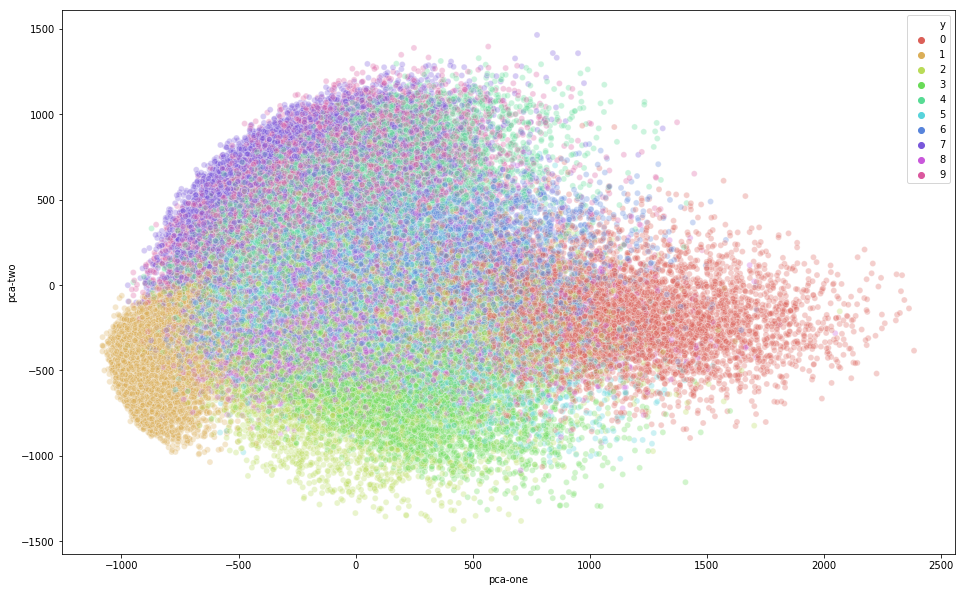

In [8]:
# Plot dataset with 2 PCA features, using same colour for data from each digit
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df.loc[rndperm,:],
    legend="full",
    alpha=0.3
)

We can see that even with 2 components, we can see a degree of separation between the data for each of the digits. However there is some overlap as well, so this is still not ideal for distinguishing the digits.

Lets see if we include all 3 PCA components if the separation is better, and we can plot this on a 3d scatterplot.

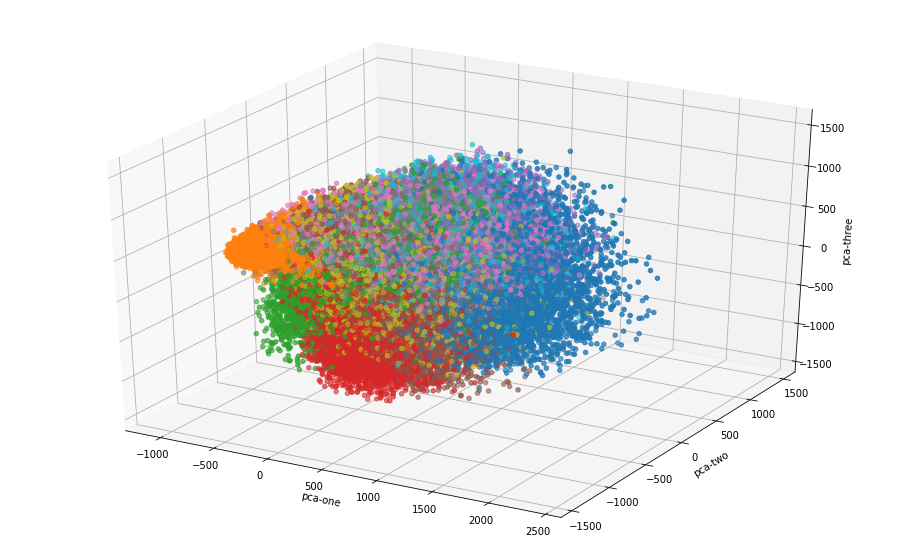

In [9]:
# Plot dataset with 3 PCA features, using same colour for data from each digit
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df.loc[rndperm,:]["pca-one"], 
    ys=df.loc[rndperm,:]["pca-two"], 
    zs=df.loc[rndperm,:]["pca-three"], 
    c=df.loc[rndperm,:]["y"].astype(int), 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

The separation between the digit data might be a little better, but there is still a high degree of overlap between the data for each of the digits.

## Reduce dimensionality using t-SNE

t-Distributed Stochastic Neighbor Embedding (t-SNE) is an unsupervised, non-linear technique primarily used for data exploration and visualizing high-dimensional data. In simpler terms, t-SNE gives you a feel or intuition of how the data is arranged in a high-dimensional space.

#### t-SNE vs PCA

What is the difference between t-SNE and PCA? PCA was developed much earlier (in 1933) whereas t-SNE was developed much more recently (in 2008) so much has changed in this time. t-SNE also differs from PCA by preserving only small pairwise distances or local similarities whereas PCA is concerned with preserving large pairwise distances to maximize variance. This difference can potentially allow more of the varience to be preserved using t-SNE.

Let us first take a subset of the PCA transformed data which we will use later.

In [10]:
# Run PCA on subset
N = 10000
df_subset = df.loc[rndperm[:N],:].copy()
data_subset = df_subset[feat_cols].values
pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.09819946 0.07123677 0.06113222]


In [11]:
df_subset.head()

pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
46730     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
48393     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
41416     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
34506     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
43725     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

       pixel9  ...  pixel779  pixel780  pixel781  pixel782  pixel783  y  \
46730     0.0  ...       0.0       0.0       0.0       0.0       0.0  8   
48393     0.0  ...       0.0       0.0       0.0       0.0       0.0  4   
41416     0.0  ...       0.0       0.0       0.0       0.0       0.0  8   
34506     0.0  ...       0.0       0.0       0.0       0.0       0.0  7   
43725     0.0  ...       0.0       0.0       0.0       0.0       0.0  7   

       label     pca-one     pca-two   pca-three  
46730      8  745.381094  430.142234 -339.422986  
48393      4 -220.059535 -635.206659 -366.892667  
41416      8  -81.381346  106.704552 -509.199413  
34506      7 -458.069785 -470.603757 -240.321950  
43725      7 -416.229525 -478.041909  394.779982  

[5 rows x 789 columns]

Now we will extract 2 t-SNE components from the dataset

In [12]:
# Create 2 components using t-SNE
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 1.156s...
[t-SNE] Computed neighbors for 10000 samples in 119.898s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 438.329018
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.188980
[t-SNE] KL divergence after 300 iterations: 2.830714
t-SNE done! Time elap

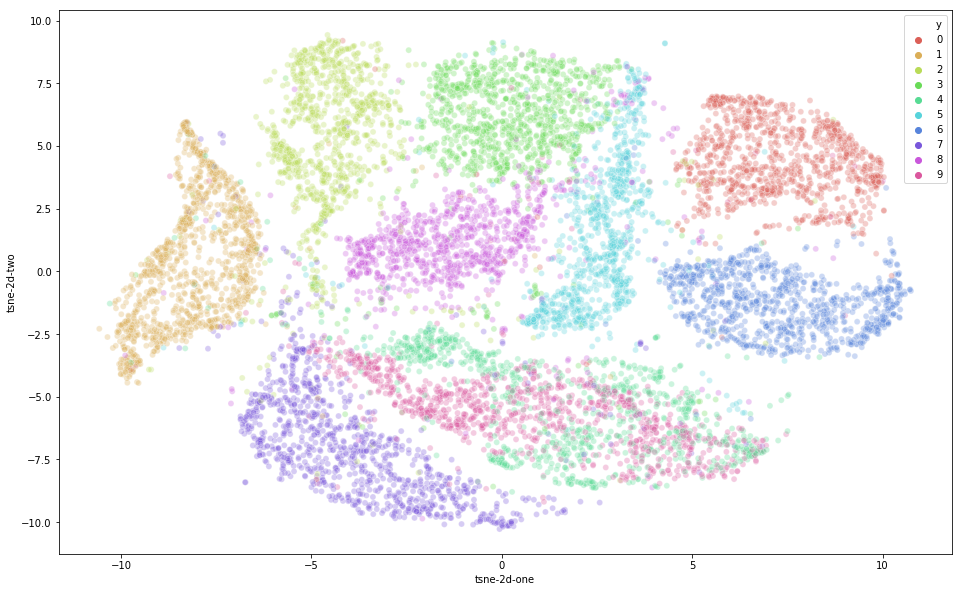

In [13]:
# Plot dataset with 2 t-SNE features, using same colour for data from each digit
df_subset['tsne-2d-one'] = tsne_results[:,0]
df_subset['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

Here we can see a much nicer and clearer separation of the datapoints for each digit, clustered in their own sub-groups.

If we would now use a clustering algorithm to pick out the seperate clusters we could probably quite accurately assign new points to a label. 

Let's just compare side by side the PCA and t-SNE plots.

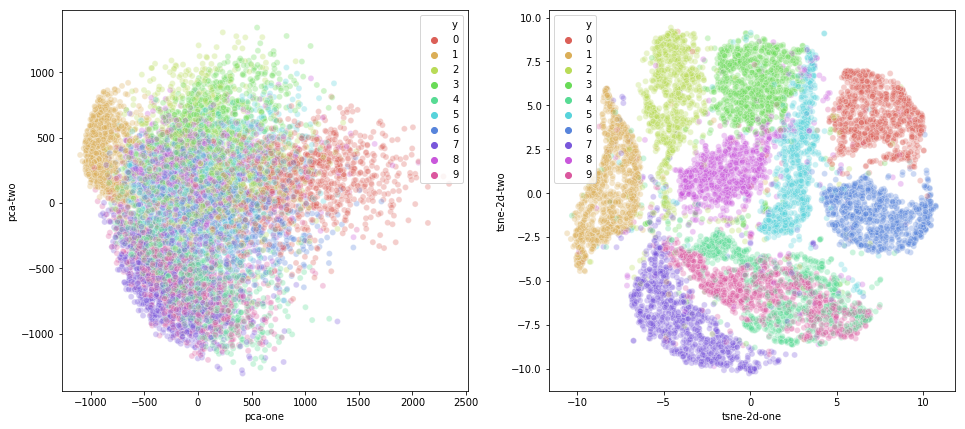

In [14]:
# Plot PCA and t-SNE datapoints side by side, coloured by digit
plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)

Lets try applying PCA first but with a higher number of components extracted, and then feed this into t-SNE

In [15]:
pca_50 = PCA(n_components=50)
pca_result_50 = pca_50.fit_transform(data_subset)
print('Cumulative explained variation for 50 principal components: {}'.format(np.sum(pca_50.explained_variance_ratio_)))

Cumulative explained variation for 50 principal components: 0.82616105907614


So it seems like the first 50 PCA components explain 82% of the varience.

Lets now take our reduced sample set to make sure its more easily computed to compare these different approaches so far.

In [16]:
# Apply t-SNE to enhanced PCA components
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_pca_results = tsne.fit_transform(pca_result_50)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 46.66536498069763 seconds


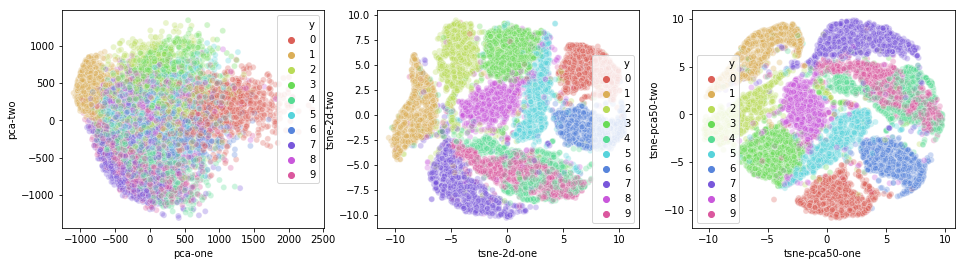

In [17]:
# Plot original PCA v original t-SNE v PCA+t-SNE
df_subset['tsne-pca50-one'] = tsne_pca_results[:,0]
df_subset['tsne-pca50-two'] = tsne_pca_results[:,1]
plt.figure(figsize=(16,4))
ax1 = plt.subplot(1, 3, 1)
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax1
)
ax2 = plt.subplot(1, 3, 2)
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax2
)
ax3 = plt.subplot(1, 3, 3)
sns.scatterplot(
    x="tsne-pca50-one", y="tsne-pca50-two",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3,
    ax=ax3
)

We can see how both the t-SNE and PCA enhanced t-SNE datasets have very nice groupings for the data for each digit, which could be very useful for example for any clustering or deep learning model.

## Discovering the 'shape' of data using TDA

PCA and t-SNE are both dimensionality reduction techniques i.e. every point in some high dimensional space gets assigned coordinates in some low dimensional space (typically two dimensions). Topological data analysis on the other hand, produces a more abstract representation of the data (a 'simplicial complex' summary of the original data).  This complex could be said to represent the **shape** of the data. The complex does not come with coordinates and should be considered a combinatorial representation of topological (and geometric) features of the original space.

A topological network (i.e. a graph) produced by TDA represents data by grouping similar data points into nodes, and connecting those nodes by an edge if the corresponding collections have a data point in common.  Because each node represents multiple data points, the network gives a compressed version of extremely high dimensional datasets.

TDA itself however can use dimensionality reduction schemes as part of the complex creation process - in fact - this is frequently very useful and many (including t-SNE) are used as "lenses".

But what is a 'lens'? to quote [Gurjeet Singh](https://www.quora.com/In-the-topological-data-analysis-approach-pioneered-by-Ayasdi-what-is-the-purpose-of-constructing-a-network-connecting-overlapping-clusters) (co-founder of Ayasdi - a pioneer in the field of TDA):

> "Imagine a circle in 3D space and imagine looking at it 'side-on' - you would see a line segment. This is a fine projection (lens), but loses the connectivity structure of the data - the fact that its connected up like a loop. Constructing edges allows us to see that. In other words, the edges reveal and allow us to interrogate the connectivity structure of the underlying data."

TDA seeks to compare or understand global invariants of a dataset (persistent homology and its cousins) that characterise the **shape** of the data, or partition data for further applications of machine learning (Morse-Smale clustering, Mapper algorithm). TDA is a relatively recent technique, popularized in a [landmark paper by Gunnar Carlsson in 2009](http://www.ams.org/journals/bull/2009-46-02/S0273-0979-09-01249-X/S0273-0979-09-01249-X.pdf).

In this project we will make use of the mapper algorithm on our MNIST digits dataset.

In [18]:
# Load digits dat
data, labels = datasets.load_digits().data, datasets.load_digits().target

In [ ]:
# Select similar subset of dataset as previous
N = 10000
df_subset2 = df.loc[rndperm[:N],:].copy()
df_subset2 = df_subset2.reset_index()
data_subset2 = df_subset2[feat_cols].values

In [20]:
# Initialize to use t-SNE with 2 components (reduces data to 2 dimensions). Also note high overlap_percentage.
mapper = km.KeplerMapper(verbose=2)

# Fit and transform data
projected_data = mapper.fit_transform(data_subset2,
                                      projection=sklearn.manifold.TSNE())

# Create the graph (we cluster on the projected data and suffer projection loss)
graph = mapper.map(projected_data,
                   clusterer=sklearn.cluster.DBSCAN(eps=0.3, min_samples=15),
                   cover=km.Cover(35, 0.2))

# Create the visualizations (increased the graph_gravity for a tighter graph-look.)
print("Output graph examples to html" )
# Tooltips with the target y-labels for every cluster member
mapper.visualize(graph,
                 title="Handwritten digits Mapper",
                 path_html="tda_mnist_digits.html",
                 color_function=df_subset2['y'].values,
                 custom_tooltips=df_subset2['y'].values)

KeplerMapper()
..Composing projection pipeline of length 1:
	Projections: TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
     method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
     n_components=2, n_iter=1000, n_iter_without_progress=300, perplexity=30.0,
     random_state=None, verbose=0)
	Distance matrices: False
	Scalers: MinMaxScaler(copy=True, feature_range=(0, 1))
..Projecting on data shaped (10000, 784)

..Projecting data using: 
	TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
     method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
     n_components=2, n_iter=1000, n_iter_without_progress=300, perplexity=30.0,
     random_state=None, verbose=2)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.991s...
[t-SNE] Computed neighbors for 10000 samples in 115.015s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities f

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

Cube_215 is empty.

Cube_216 is empty.

Cube_217 is empty.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

Cube_221 is empty.

Cube_222 is empty.

Cube_223 is empty.

Cube_224 is empty.

Cube_225 is empty.

Cube_226 is empty.

Cube_227 is empty.

Cube_228 is empty.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

Cube_244 is empty.

Cube_245 is empty.

Cube_246 is empty.

Cube_247 is empty.

Cube_248 is empty.

Cube_249 is empty.

Cube_250 is empty.

Cube_251 is empty.

Cube_252 is empty.

Cube_253 is empty.

Cube_254 is empty.

Cube_255 is empty.

Cube_256 is empty.

Cube_257 is empt

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

Cube_658 is empty.

Cube_659 is empty.

Cube_660 is empty.

Cube_661 is empty.

Cube_662 is empty.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

Cube_668 is empty.

   > Found 1 clusters.

Cube_670 is empty.

Cube_671 is empty.

Cube_672 is empty.

Cube_673 is empty.

Cube_674 is empty.

Cube_675 is empty.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

Cube_685 is empty.

Cube_686 is empty.

Cube_687 is empty.

Cube_688 is empty.

   > Found 1 clusters.

Cube_690 is empty.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1 clusters.

   > Found 1

'<!DOCTYPE html>\n<html>\n\n<head>\n  <meta charset="utf-8">\n  <meta name="generator" content="KeplerMapper">\n  <title>Handwritten digits Mapper | KeplerMapper</title>\n\n  <link rel="icon" type="image/png" href="http://i.imgur.com/axOG6GJ.jpg" />\n\n  <link href=\'https://fonts.googleapis.com/css?family=Roboto+Mono:700,300\' rel=\'stylesheet\' type=\'text/css\'>\n  <style>* {\n  margin: 0;\n  padding: 0;\n}\n\nhtml, body {\n  height: 100%;\n}\n\nbody {\n  font-family: "Roboto Mono", "Helvetica", sans-serif;\n  font-size: 14px;\n}\n\n#logo {\n  position: absolute;\n  right: 00px;\n  top: 0px;\n  width: 90px;\n  height: 90px;\n  z-index: 999999;\n}\n\n#display {\n  color: #95A5A6;\n  background: #212121;\n}\n\n#print {\n  color: #000;\n  background: #FFF;\n}\n\nh1 {\n  font-size: 21px;\n  font-weight: 300;\n  font-weight: 300;\n}\n\nh2 {\n  font-size: 18px;\n  padding-bottom: 20px;\n  font-weight: 300;\n}\n\nh3 {\n  font-size: 14px;\n  font-weight: 700;\n  text-transform: uppercase;\n

![title](img/tda1.png)

![title](img/tda2.png)

<Figure size 432x288 with 0 Axes>

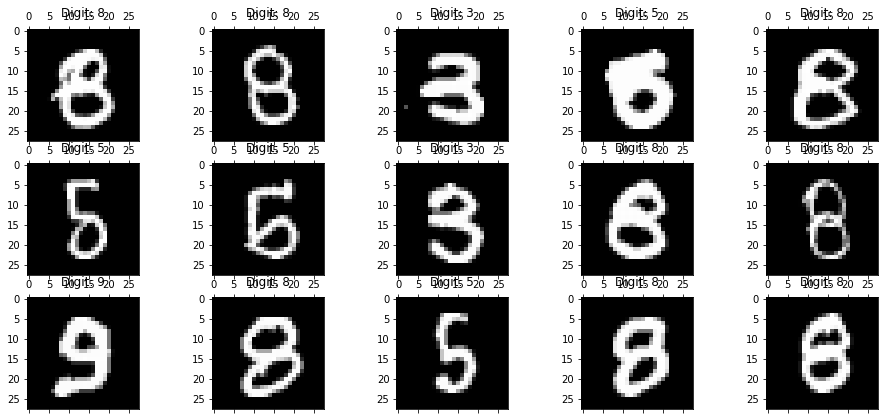

In [33]:
# Cluster A (5/3/8)
# cube264_cluster0
# Print examples
clusterA = graph.get("nodes").get("cube264_cluster0")

plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1, title="Digit: {}".format(str(df_subset2.loc[clusterA[i],'label'])) )
    ax.matshow(df_subset2.loc[clusterA[i],feat_cols].values.reshape((28,28)).astype(float))
plt.show()

<Figure size 432x288 with 0 Axes>

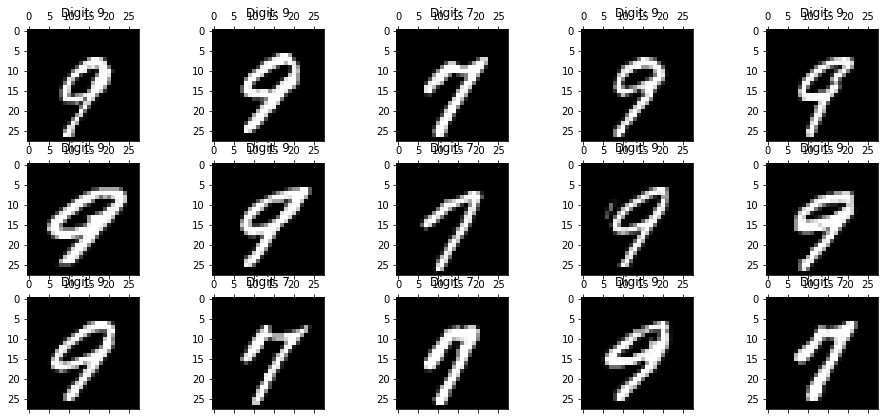

In [28]:
# Cluster B (7/9)
# cube264_cluster0
clusterB = graph.get("nodes").get("cube639_cluster0")

plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1, title="Digit: {}".format(str(df_subset2.loc[clusterB[i],'label'])) )
    ax.matshow(df_subset2.loc[clusterB[i],feat_cols].values.reshape((28,28)).astype(float))
plt.show()

## Discussion

https://hackernoon.com/data-inspired-5c78db3999b2